In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from numpy import savez_compressed
from numpy import load
import random

from paths import dataset_paths
from helper_functions import create_list
from helper_functions import resize_and_keep_ratio
from helper_functions import crop_image
from helper_functions import load_and_split_data

In [3]:
def crop_image_triplet_loss(image, crop_width):
    """
    Crops an random part out of an image and display the cropped area
    
    Arguments:
        image: image in an numpy array format
        width: int value width desired crop width
        
    Return:
        Cropped image in an numpy array format
    """
    #Convert PIL Image object into numpy array
    img_array = np.array(image)
    #select random point on x-axis and crop the image
    x_max = img_array.shape[1] - crop_width
    x_1 = np.random.randint(0, x_max)
    x_2 = np.random.randint(0, x_max)
    crop_1 = img_array[0:crop_width, x_1: x_1 + crop_width]
    crop_2 = img_array[0:crop_width, x_2: x_2 + crop_width]

    return crop_1, crop_2

In [4]:
def create_triplet_dataset(dataset_size, height, width, path, rgb=False):
    
    if rgb == True:
        #create empty arrays for rgb data
        anchors = np.zeros([dataset_size, height, width, 3])
        positives = np.zeros([dataset_size, height, width, 3])
        negatives = np.zeros([dataset_size, height, width, 3])
        y = np.zeros([dataset_size, 0])
    else: 
        #create empty arrays for grayscale data
        anchors = np.zeros([dataset_size, height, width, 1])
        positives = np.zeros([dataset_size, height, width, 1])
        negatives = np.zeros([dataset_size, height, width, 1])
        y = np.zeros([dataset_size, 0])
        
    i = 0
    
    while i < dataset_size:
        #Select two random folders for anchor/positive and negative samples and save the paths to lists
        list_anchor_positive, list_negative = random.sample(dataset_paths, 2)
        list_anchor_positive = create_list(list_anchor_positive)
        list_negative = create_list(list_negative)
        
        #load two images for anchor/positive and negative from disk and preprocess it
        image_anchor_positive = resize_and_keep_ratio(list_anchor_positive, height, rgb)
        image_negative = resize_and_keep_ratio(list_negative, height, rgb)
        
        #new cycle if one of the 2 loaded images is 0
        if image_anchor_positive == 0 or image_negative == 0:
            pass
        else:
            if rgb == True:
                anchor, positive = (crop_image_triplet_loss(image_anchor_positive, width))
                anchors[i] = anchor / 255.
                positives[i] = positive / 255.
                negatives[i] = (crop_image(image_negative, width)) / 255.
                y[i] = 0
                
            else:
                anchor, positive = (crop_image_triplet_loss(image_anchor_positive, width))
                anchors[i] = anchor / 255.
                positives[i] = positive / 255.
                negative[i] = (crop_image(image_negative, width)) / 255.
                y[i] = 0
        
            i += 1
        
    return[anchors, positives, negatives], y

In [ ]:
x, y = create_triplet_dataset(5000, 224, 224, dataset_paths, rgb=True)

In [6]:
def save_triplet_arrays(x, y, sample_size, rgb=False):
    """
    Function for saving numpy arrays in numpy .npz format on disc
    
    Arguments:
        sample_size: Number of image pairs in int format
        x: x data as numpy array
        y: y data as numpy array
        rgb: npz extension if rgb or grayscale images
    
    Returns:
        Print statement if saving is successfull
    """
    if rgb == True:
        savez_compressed(f'npz_datasets/data_x_{sample_size}_rgb_triplet.npz', x)
        savez_compressed(f'npz_datasets/data_y_{sample_size}_rgb_triplet.npz', y)
    else:
        savez_compressed(f'npz_datasets/data_x_{sample_size}_gray_triplet.npz', x)
        savez_compressed(f'npz_datasets/data_y_{sample_size}_gray_triplet.npz', y)
    print("saved successfully")

In [9]:
sample_size = 5000
save_triplet_arrays(x, y, sample_size, rgb=True)

saved successfully


In [60]:
%%time
train_dataset, test_dataset, val_dataset = load_and_split_data("npz_datasets/data_x_5000_rgb_triplet.npz", "npz_datasets/data_y_5000_rgb_triplet.npz", split_size=80, batch_size=128, triplet=True)

CPU times: user 27.2 s, sys: 5.93 s, total: 33.1 s
Wall time: 33.1 s


In [38]:
train_dataset.take(1)

<TakeDataset shapes: (((None, 224, 224, 3), (None, 224, 224, 3), (None, 224, 224, 3)), (None, 0)), types: ((tf.float64, tf.float64, tf.float64), tf.float64)>

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K

In [20]:
alpha = 0.2
emb_size = 128

def triplet_loss(y_true, y_pred):
    anchor, positive, negative = y_pred[:,:emb_size], y_pred[:,emb_size:2*emb_size], y_pred[:,2*emb_size:]
    #anchor, positive, negative = y_pred
    positive_dist = tf.reduce_mean(tf.square(anchor - positive), axis=1)
    negative_dist = tf.reduce_mean(tf.square(anchor - negative), axis=1)
    return tf.maximum(positive_dist - negative_dist + alpha, 0.)

In [64]:
img_width = 224
img_height = 224

In [65]:
#Set seed
tf.random.set_seed(42)

base_model = tf.keras.applications.vgg16.VGG16(include_top=False)
base_model.trainable = False

inputs = keras.layers.Input((img_width, img_height, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(512, activation="relu")(x)
x = keras.layers.Dropout(0.1)(x)
outputs = keras.layers.Dense(128, activation="relu")(x)

base_model_vgg_16 = keras.models.Model(inputs, outputs)

In [66]:
base_model_vgg_16.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               65664     
Total params: 15,043,008
Trainable params: 328,320
Non-trainable params: 14,714,688
_________________________________________

In [67]:
input_anchor = keras.layers.Input((img_width, img_height, 3))
input_positive = keras.layers.Input((img_width, img_height, 3))
input_negative = keras.layers.Input((img_width, img_height, 3))

feat_vect_anchor = base_model_vgg_16(input_anchor)
feat_vect_positive = base_model_vgg_16(input_positive)
feat_vect_negative = base_model_vgg_16(input_negative)

#output = tf.keras.layers.concatenate([feat_vect_anchor, feat_vect_positive, feat_vect_negative])
output = [feat_vect_anchor, feat_vect_positive, feat_vect_negative]

In [68]:
model_vgg_16 = keras.models.Model(inputs=[input_anchor, input_positive, input_negative], outputs=output)
model_vgg_16.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_21 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_22 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model_5 (Functional)            (None, 128)          15043008    input_20[0][0]                   
                                                                 input_21[0][0]             

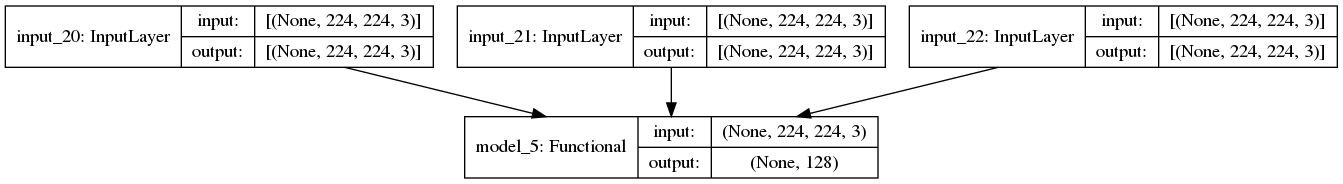

In [69]:
from keras.utils.vis_utils import plot_model

plot_model(model_vgg_16, show_shapes=True)

In [70]:
model_vgg_16.compile(loss=tfa.losses.TripletSemiHardLoss(), optimizer="Adam", metrics=["accuracy"])

In [74]:
model_vgg_16.fit(train_dataset, epochs=5)

Epoch 1/5


ValueError: in user code:

    /home/js/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:855 train_function  *
        return step_function(self, iterator)
    /home/js/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:845 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/js/.local/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/js/.local/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/js/.local/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/js/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:838 run_step  **
        outputs = model.train_step(data)
    /home/js/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:795 train_step
        y_pred = self(x, training=True)
    /home/js/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:1013 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/js/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/input_spec.py:203 assert_input_compatibility
        ' input tensors. Inputs received: ' + str(inputs))

    ValueError: Layer model_6 expects 3 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 224, 224, 3) dtype=float64>]


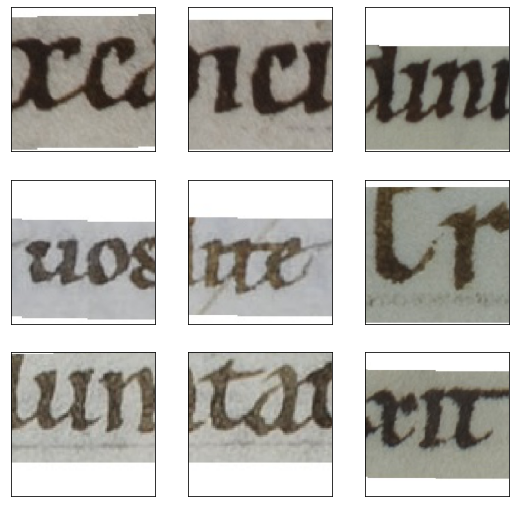

In [75]:
import matplotlib.pyplot as plt
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])


visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])